# ASO and ATL08: Spatial Extent Comparison

In [ ]:
!pip install earthpy

In [41]:
#Open, Plot, and Explore Raster Data with Python 
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/
#Applied to ASO Snow Off data from Tuolumne Meadows (downloaded from Linux Box Storage)

# Import necessary packages
import os
import rasterio
from rasterio.enums import Resampling
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from rasterstats import zonal_stats
import statistics
import scipy.stats as stats
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from rasterio import features

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

In [2]:
#set working directory?
os.chdir(os.path.join(et.io.HOME, 
                      'ICESat-2_Snowdepth'))

In [3]:
dem_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif")
dem_9m_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif")

In [4]:
ATL08_path = os.path.join("data/ATL08_simplified/")

In [5]:
# # Proceess and Open Snow-Off Data
# # Open the file using a context manager ("with rio.open" statement)

# with rio.open(dem_path) as dem:
#     dem_arr = dem.read(1)
#     dem_meta = dem.profile
#     dem_plot_ext = plotting_extent(dem)
#     print(dem.crs)

# #Clean raster by removing zero values
# dem_arr[dem_arr == (-9999.)] = np.nan
# dem_arr[dem_arr == (0.)] = np.nan

# print(dem_plot_ext)
# xmin,ymin,xmax,ymax = dem.bounds

In [6]:
# Proceess and Open Snow-Off Data
# Open the file using a context manager ("with rio.open" statement)

with rio.open(dem_9m_path) as dem_9m:
    dem_9m_arr = dem_9m.read(1)
    dem_9m_meta = dem_9m.profile
    dem_9m_plot_ext = plotting_extent(dem_9m)
    print(dem_9m.crs)

#Clean raster by removing zero values
dem_9m_arr[dem_9m_arr == (-9999.)] = np.nan
dem_9m_arr[dem_9m_arr == (0.)] = np.nan

print(dem_9m_plot_ext)
xmin_9m,ymin_9m,xmax_9m,ymax_9m = dem_9m.bounds

EPSG:32611
(254247.0, 307338.0, 4179330.0, 4229667.0)


In [61]:
filetype = '*.csv'

files = [f for f in os.listdir(ATL08_path) if f.endswith(filetype[1:])]

In [8]:
# def open_atl08(fname):
    
#     df = pd.read_csv(ATL08_path+fnameb, index_col=0)
#     globals()[f'gdf{fname[20:22]}_{fname[10:14]}'] = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.x, df.y))
#     print(f'gdf{fname[20:22]}_{fname[10:14]}')
#     return globals()[f'gdf{fname[20:22]}_{fname[10:14]}']

In [62]:
summer_2020_tracks = glob.glob(ATL08_path + "/*.csv")
summer_2020_tracks

['data/ATL08_simplified/ATL08_20200805035_gt3l.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt2l.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt3l.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt1l.csv',
 'data/ATL08_simplified/ATL08_20201006010_gt1r.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt3r.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt1r.csv',
 'data/ATL08_simplified/ATL08_20201006010_gt1l.csv',
 'data/ATL08_simplified/ATL08_20201006010_gt3r.csv',
 'data/ATL08_simplified/ATL08_20200810153_gt1l.csv',
 'data/ATL08_simplified/ATL08_20200810153_gt1r.csv',
 'data/ATL08_simplified/ATL08_20200805035_gt3r.csv',
 'data/ATL08_simplified/ATL08_20201011123_gt2r.csv',
 'data/ATL08_simplified/ATL08_20200805035_gt1r.csv',
 'data/ATL08_simplified/ATL08_20200810153_gt3l.csv',
 'data/ATL08_simplified/ATL08_20200805035_gt2l.csv',
 'data/ATL08_simplified/ATL08_20200805035_gt1l.csv',
 'data/ATL08_simplified/ATL08_20201006010_gt2l.csv',
 'data/ATL08_simplified/ATL08_20200810153_gt2l

In [63]:
track_names = []
for file in files:
    track_names.append(f'gdf{file[20:22]}_{file[10:14]}')

In [11]:
track_names

['gdf3l_0805',
 'gdf2l_1011',
 'gdf3l_1011',
 'gdf1l_1011',
 'gdf1r_1006',
 'gdf3r_1011',
 'gdf1r_1011',
 'gdf1l_1006',
 'gdf3r_1006',
 'gdf1l_0810',
 'gdf1r_0810',
 'gdf3r_0805',
 'gdf2r_1011',
 'gdf1r_0805',
 'gdf3l_0810',
 'gdf2l_0805',
 'gdf1l_0805',
 'gdf2l_1006',
 'gdf2l_0810',
 'gdf2r_1006',
 'gdf3r_0810',
 'gdf1l_0908',
 'gdf2r_0810',
 'gdf3l_1006',
 'gdf2r_0805']

In [64]:
def open_atl08(data_files):
    
    atlas_df = pd.concat((pd.read_csv(f) for f in data_files), keys=track_names)
    atlas_df = atlas_df.reset_index(level=1, drop=True).rename_axis('Track').reset_index()
    atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))
    return atlas_gdf

In [65]:
summer_2020_gdf = open_atl08(summer_2020_tracks)

In [14]:
summer_2020_gdf.head()

,Track,Unnamed: 0,h_te_mean,h_te_median,h_te_min,h_te_max,latitude,longitude,h_te_mode,h_te_skew,n_te_photons,segment_snowcover,terrain_slope,h_te_uncertainty,dem_h,x,y,geometry
0,gdf3l_0805,0,2447.312988,2447.840820,2443.869141,2452.251709,38.218349,-119.357941,2450.900146,0.120472,43.0,1.0,0.096521,56.914291,2432.245361,293580.632058,4.232670e+06,POINT (293580.632 4232670.375)
1,gdf3l_0805,1,2461.752441,2460.400635,2452.439209,2472.410645,38.217449,-119.358040,2470.900146,0.323581,47.0,1.0,0.224312,52.377888,2438.760254,293569.403002,4.232571e+06,POINT (293569.403 4232570.686)
2,gdf3l_0805,2,2467.020752,2466.710449,2463.988281,2472.694580,38.216553,-119.358154,2468.400146,0.526934,65.0,1.0,0.018781,37.954182,2446.151123,293556.848568,4.232471e+06,POINT (293556.849 4232471.454)
3,gdf3l_0805,3,2482.650391,2484.794678,2471.965576,2487.378418,38.215652,-119.358246,2486.900146,-0.921623,50.0,1.0,0.148027,49.653111,2454.659912,293546.287177,4.232372e+06,POINT (293546.287 4232371.748)
4,gdf3l_0805,4,2489.645020,2489.964844,2487.116455,2491.242188,38.214752,-119.358345,2491.000000,-0.635667,102.0,1.0,0.019139,24.408291,2463.780518,293535.057622,4.232272e+06,POINT (293535.058 4232272.059)


In [15]:
type(summer_2020_gdf)

geopandas.geodataframe.GeoDataFrame

In [16]:
summer_2020_gdf.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 120°W to 114°W - by country
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

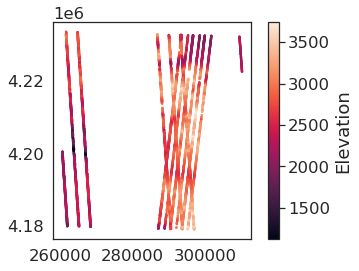

In [17]:
summer_2020_gdf.plot(column='h_te_median', s=2, legend=True, legend_kwds={'label': "Elevation", 'orientation': "vertical"});

In [18]:
# atl08 =  gpd.GeoDataFrame()

# for file in files:
#     atl08 =+ gpd.GeoDataFrame(open_atl08(file), crs='epsg:32611', geometry=globals()[f'gdf{file[20:22]}_{file[10:14]}'].geometry)
#     atl08['track'] = globals()[f'gdf{file[20:22]}_{file[10:14]}']

In [19]:
# atl08 =  gpd.GeoDataFrame()

# for file in files:
#     atl08 =+ open_atl08(file)
#     #atl08['track'] = globals()[f'gdf{file[20:22]}_{file[10:14]}']

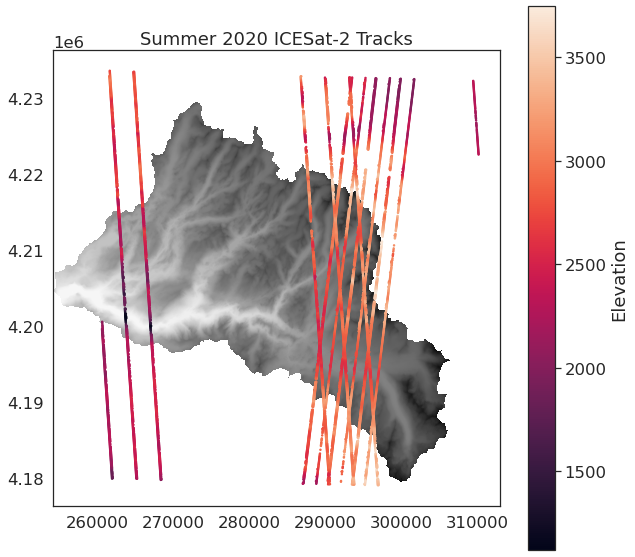

In [20]:
f, ax = plt.subplots(figsize = (10,10))
plt.title('Summer 2020 ICESat-2 Tracks')
im = ax.imshow(dem_9m_arr, cmap='Greys', extent=[xmin_9m,xmax_9m,ymin_9m,ymax_9m])
summer_2020_gdf.plot(column='h_te_median', ax=ax, s=2, legend=True, legend_kwds={'label': "Elevation", 'orientation': "vertical"});

In [21]:
# f, ax = plt.subplots(figsize = (10,10))
# plt.title('Summer 2020 ICESat-2 Tracks')
# im = ax.imshow(dem_9m, cmap='Greys', extent=[xmin,xmax,ymin,ymax])
# for track in tracks:
#     track.plot(ax=ax, markersize=0.1)

# Mask with ASO Roughness

In [22]:
dtm_fns = glob.glob('data/**/*.tif',recursive=True)
dtm_fns

['data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_gdaldem_tri.tif',
 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif',
 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_gdaldem_rough.tif',
 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif']

In [23]:
dtm_fn = dtm_fns[0] # change which of the three tif files to look at
imgdir = 'data/'

In [24]:
src = rio.open(dtm_fn)
tm = src.read()

In [25]:
tm[tm == (-9999.)] = np.nan
tm[tm == 0] = np.nan

In [26]:
import numpy.ma as ma
#https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_where.html#numpy.ma.masked_where
tm_max_mask = ma.masked_where(tm > 6, tm) #Mask to remove values above a ceratin value

In [ ]:
tm_max_mask

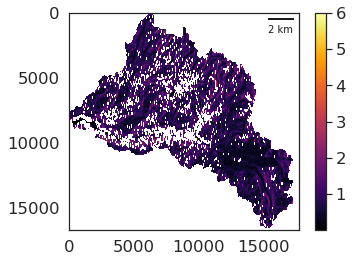

In [27]:
#Plot full range
f,ax = plt.subplots()
plt.imshow(tm_max_mask.squeeze(), cmap='inferno')
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [29]:
#summer_2020_gdf_clipped = gpd.clip(summer_2020_gdf, tm_max_mask, keep_geom_type=False)

In [ ]:
type(tm_max_mask)

In [ ]:
tm_max_mask.gpd.GeoDataFrame()

# Masking with David's code

In [104]:
slope_9m_path = os.path.join("data",
                       "ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif")
out_fn = os.path.join('data',
                     'ASO_3m_dtm_USCATM__gdaldem_slope_9m_output.tif')
tuol_basin_fn = os.path.join('data',
                             'UpperTuolRiverBasin',
                            'UpperTuolRiverBasinOutline.shp')

In [106]:
tuol_basin = gpd.read_file(tuol_basin_fn)

<AxesSubplot:>

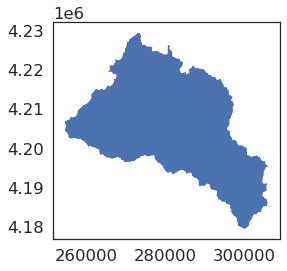

In [108]:
tuol_basin.plot()

In [7]:
#!gdaladdo -r gauss $slope_9m_path

0...10...20...30...40...50...60...70...80...90...100 - done.


In [37]:
dem_9m_path

'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif'

In [38]:
# aso_feat_list = []
# ovr_scale = 8
# for fn in aso_fn_list:
#     src = rio.open(fn)
#     a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
#     ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
#     mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
#     shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
#     geom_list = list(shapes)
#     dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
#     aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])

    
# aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
# #remove tiny polygons
# area_thresh = 1e8
# aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]
# #Shoud simplify and sieve

In [109]:
aso_feat_list = []
ovr_scale = 8
src = rio.open(fn)
a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
b = ma.masked_where(a > 20, a)
mask = np.ma.getmaskarray(b).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#remove tiny polygons
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]
#Shoud simplify and sieve

In [96]:
#geom_list

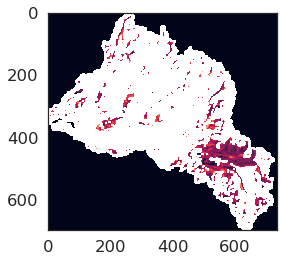

In [110]:
plt.imshow(b)

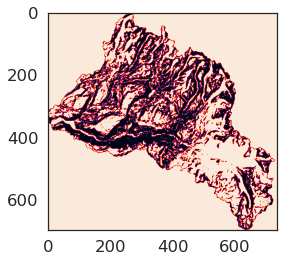

In [111]:
plt.imshow(mask)

In [112]:
aso_gdf

,geometry,fn,date
1079,"POLYGON ((254247.000 4229667.000, 254247.000 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m
1722,"POLYGON ((273336.708 4229667.000, 273336.708 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m


<AxesSubplot:>

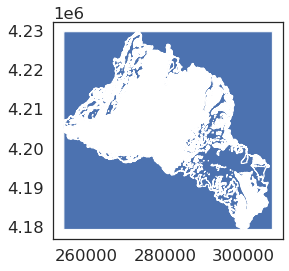

In [113]:
aso_gdf.plot()

In [126]:
summer_2020_gdf_clipped = gpd.clip(summer_2020_gdf, aso_gdf, keep_geom_type=False)

In [128]:
summer_2020_gdf_clipped = gpd.clip(summer_2020_gdf_clipped, tuol_basin, keep_geom_type=False)

<AxesSubplot:>

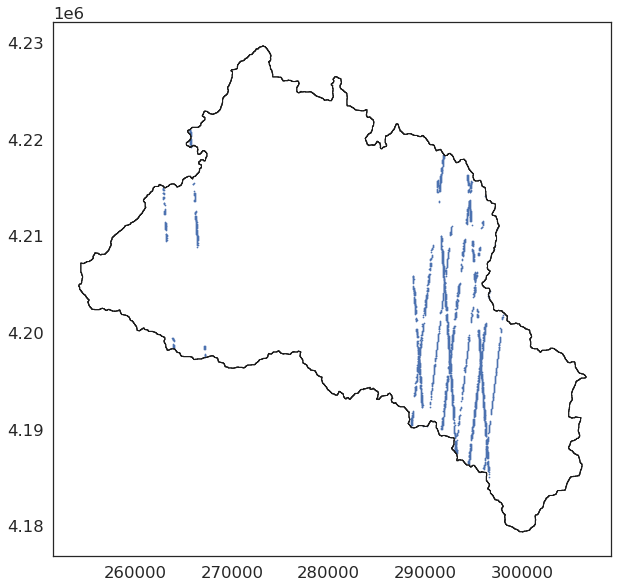

In [129]:
f, ax = plt.subplots(figsize=(10,10))
summer_2020_gdf_clipped.plot(ax=ax, markersize=0.5)
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='k')

In [ ]:
summer_2020_gdf_clipped

# Differencing ASO and ICSat-2

In [130]:
summer_2020_buffered = summer_2020_gdf_clipped.copy()
summer_2020_buffered['geometry'] = summer_2020_gdf_clipped.buffer(50)

In [131]:
summer_2020_buffered = summer_2020_buffered.dropna(0)

In [152]:
aso_elev = os.path.join('data',
                     'mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif')
aso_slope = os.path.join('data',
                     'ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif')

In [134]:
h_aso = zonal_stats(summer_2020_buffered, aso_elev, geojson_out=True, nodata=(-9999.),stats='mean')

In [177]:
summer_2020_final = gpd.GeoDataFrame.from_features(h_aso)
summer_2020_final['geometry'] = summer_2020_gdf_clipped['geometry']
summer_2020_final = summer_2020_final.rename(columns={"mean": "h_aso"})
summer_2020_final[summer_2020_final == (0.)] = np.nan
summer_2020_final.head()

,geometry,Track,Unnamed: 0,dem_h,h_te_max,h_te_mean,h_te_median,h_te_min,h_te_mode,h_te_skew,h_te_uncertainty,latitude,longitude,n_te_photons,segment_snowcover,terrain_slope,x,y,h_aso
0,None,gdf3l_0805,129,3236.311279,3223.794434,3218.714355,3219.148926,3214.213867,3219.199951,0.079751,14.498715,38.087982,-119.372688,222.0,1.0,-0.070563,291919.082038,4.218236e+06,3219.813860
1,None,gdf3l_0805,130,3233.483398,3214.471436,3207.848633,3205.720459,3202.482422,3211.300049,0.284360,14.257124,38.087086,-119.372803,225.0,1.0,-0.132471,291906.501415,4.218136e+06,3207.424626
2,None,gdf3l_0805,131,3221.446533,3202.904297,3201.590088,3202.081055,3195.596191,3202.100098,-2.470910,14.822178,38.086185,-119.372902,216.0,1.0,-0.030500,291895.248165,4.218037e+06,3203.132911
3,None,gdf3l_0805,132,3206.359863,3196.205322,3186.147705,3186.958740,3176.294434,3187.300049,-0.121724,22.126060,38.085289,-119.373024,144.0,1.0,-0.182500,291881.997966,4.217937e+06,3187.806766
4,None,gdf3l_0805,133,3188.683105,3176.509521,3167.832520,3167.701660,3160.042725,3167.600098,0.107222,14.016976,38.084389,-119.373138,226.0,1.0,-0.168150,291869.405945,4.217838e+06,3167.660939


In [178]:
# slope_aso = zonal_stats(summer_2020_buffered.geometry, aso_slope, geojson_out=True, nodata=(-9999.),stats='mean')
# summer_2020_final['slope_aso'] = slope_aso[{'mean'}]
# summer_2020_final = summer_2020_final.rename(columns={"mean": "slope_aso"})

In [179]:
summer_2020_final['difference'] = summer_2020_final['h_te_median'] - summer_2020_final['h_aso']

In [180]:
summer_2020_final[summer_2020_final['difference'] < (-250)] = np.nan
summer_2020_final[summer_2020_final['difference'] > (250)] = np.nan

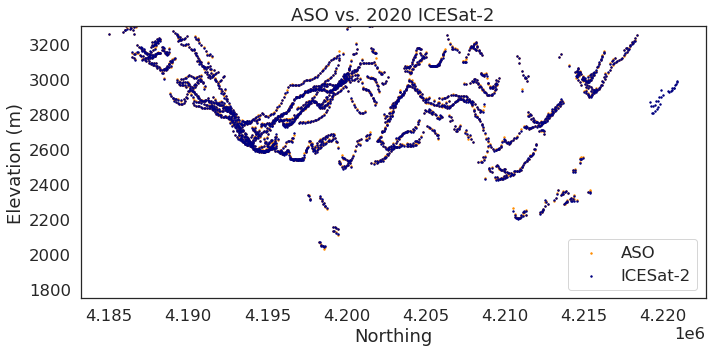

In [150]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(summer_2020_final['y'],summer_2020_final['h_aso'], c='darkorange', s=2, label = 'ASO')
ax.scatter(summer_2020_final['y'],summer_2020_final['h_te_median'], c='navy', s=2, label = 'ICESat-2')
ax.set_ylim(1750, 3300)
ax.set_xlabel('Northing')
ax.set_ylabel('Elevation (m)')
ax.set_title('ASO vs. 2020 ICESat-2')
ax.legend(loc = 'lower right')
fig.tight_layout()
plt.savefig('2020_dif_ASO_profile.jpeg', dpi=300)
#ax.set_xlim(4.196*(10**6),4.215*(10**6))

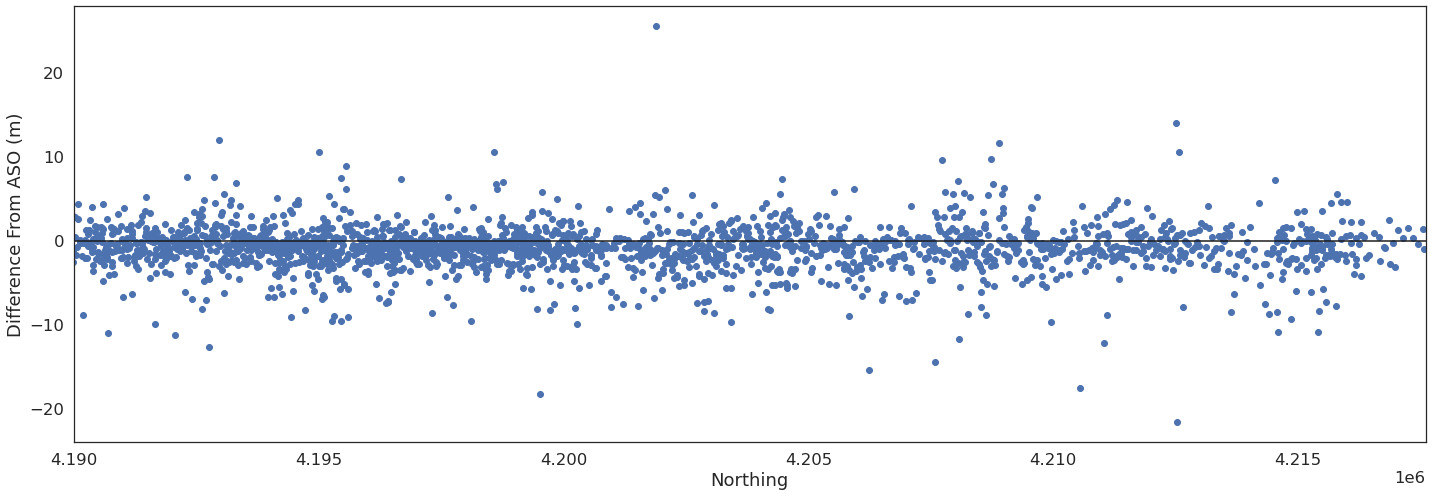

In [161]:
fig, ax = plt.subplots(figsize=(20,7))
ax.scatter(summer_2020_final['y'],summer_2020_final['difference'], cmap=summer_2020_final['slope_aso'])
ax.axhline(y=0, c='k')
plt.xlim( 4.19e+06, 4.2176e+06)
#plt.ylim(-6, 3)
plt.xlabel('Northing')
plt.ylabel('Difference From ASO (m)')
plt.tight_layout()
plt.savefig('2020_Dif.jpeg', dpi=300)

## Old Code, trying Dictionaries

In [ ]:
# tracks_d = []
# type(tracks)

In [ ]:
# type(tracks_d[1])

In [ ]:
# for file in files:
#     tracks_d.append(open_atl08_d(file))

In [ ]:
# def open_atl08_d(fname):
    
#     d = {}
#     df = pd.read_csv(ATL08_path+fname, index_col=0)
#     d[f'gdf{fname[20:22]}_{fname[10:14]}'] = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.x, df.y))
#     print(f'gdf{fname[20:22]}_{fname[10:14]}')
#     return d

In [ ]:
#open_atl08_d('ATL08_20200805035_gt1r.csv')